In [227]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.io import loadmat 
from scipy.stats import spearmanr
import pickle 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

from utils.eval import compute_sparsity_stats


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
# sluggish_vals = np.arange(0,31)
# corrs_int = []
# corrs_blocked = []
# corrs_all_b = []
# corrs_all_i = []
# for sv in sluggish_vals:
#     cmats_a = []
#     cmats_b = []
#     corrs_run_b = []
#     corrs_run_i = []
#     for r in np.arange(0,30):
#         with open('checkpoints/sluggish_sla_int_sv'+ str(sv) + '/run_' + str(r) +'/results.pkl','rb') as f:
#             results = pickle.load(f)
#             choices = results['all_y_out'][1,:]
#             cmats_a.append(choices[:25].reshape(5,5))
#             cmats_b.append(choices[25:].reshape(5,5))
#             corrs_run_b.append(spearmanr(choices_blocked,choices)[0])
#             corrs_run_i.append(spearmanr(choices_interleaved,choices)[0])
#     cmats_a = np.array(cmats_a)
#     cmats_b = np.array(cmats_b)
#     choices_mod = np.hstack((cmats_a.mean(0).flatten(),cmats_b.mean(0).flatten()))
#     corrs_int.append(spearmanr(choices_interleaved,choices_mod)[0])
#     corrs_blocked.append(spearmanr(choices_blocked,choices_mod)[0])
#     corrs_all_b.append(corrs_run_b)
#     corrs_all_i.append(corrs_run_i)
# corrs_all_b = np.array(corrs_all_b)
# corrs_all_i = np.array(corrs_all_i)


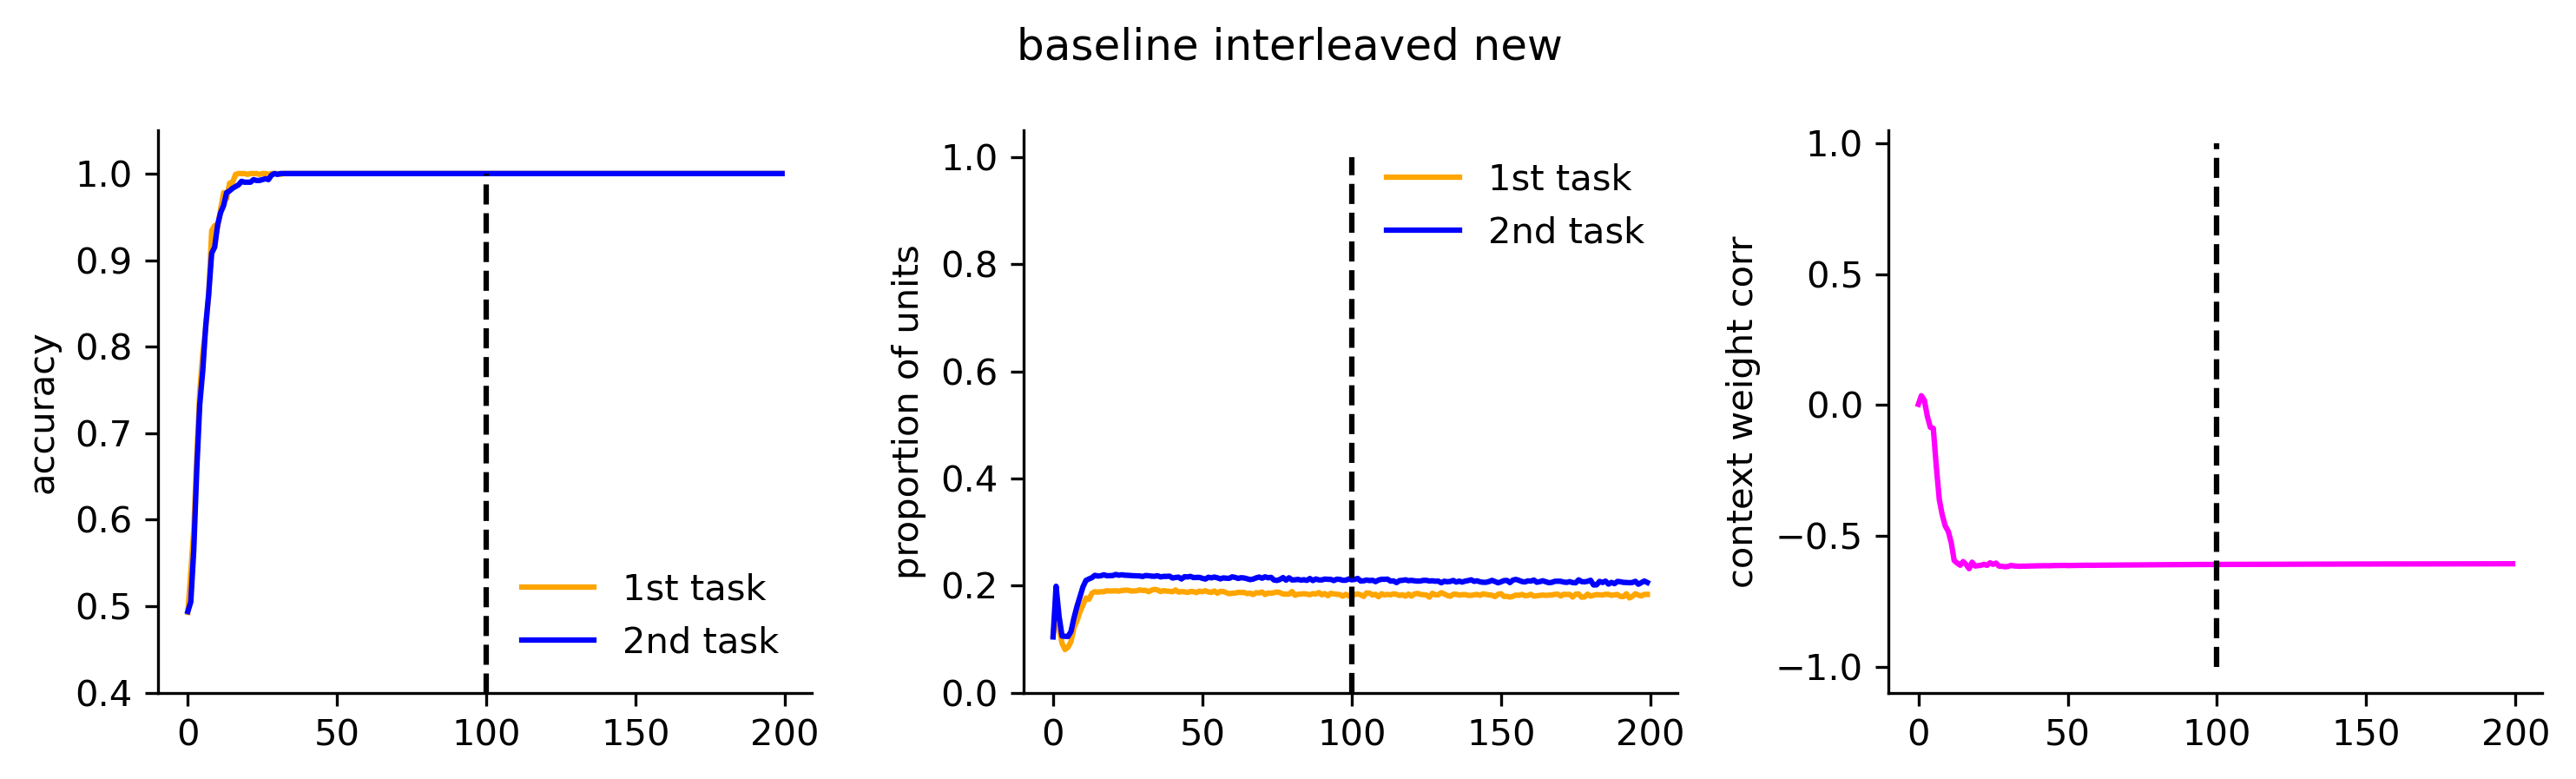

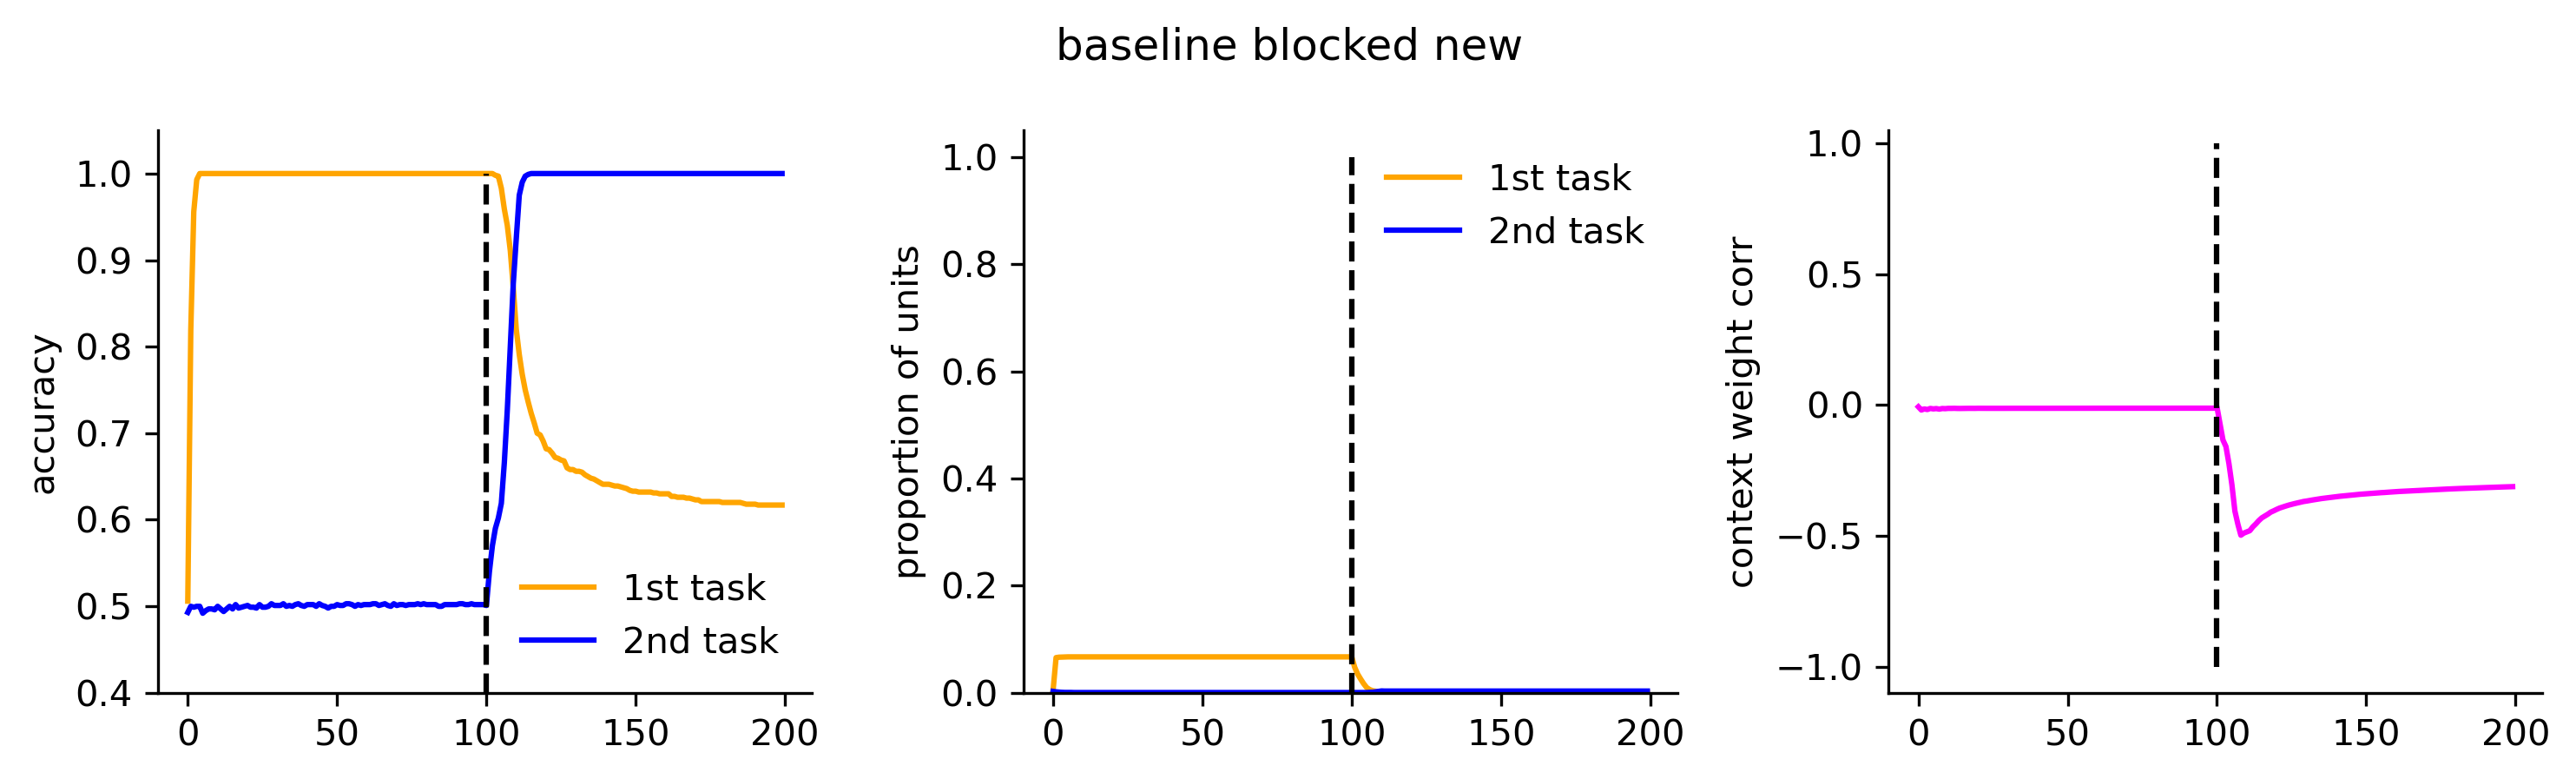

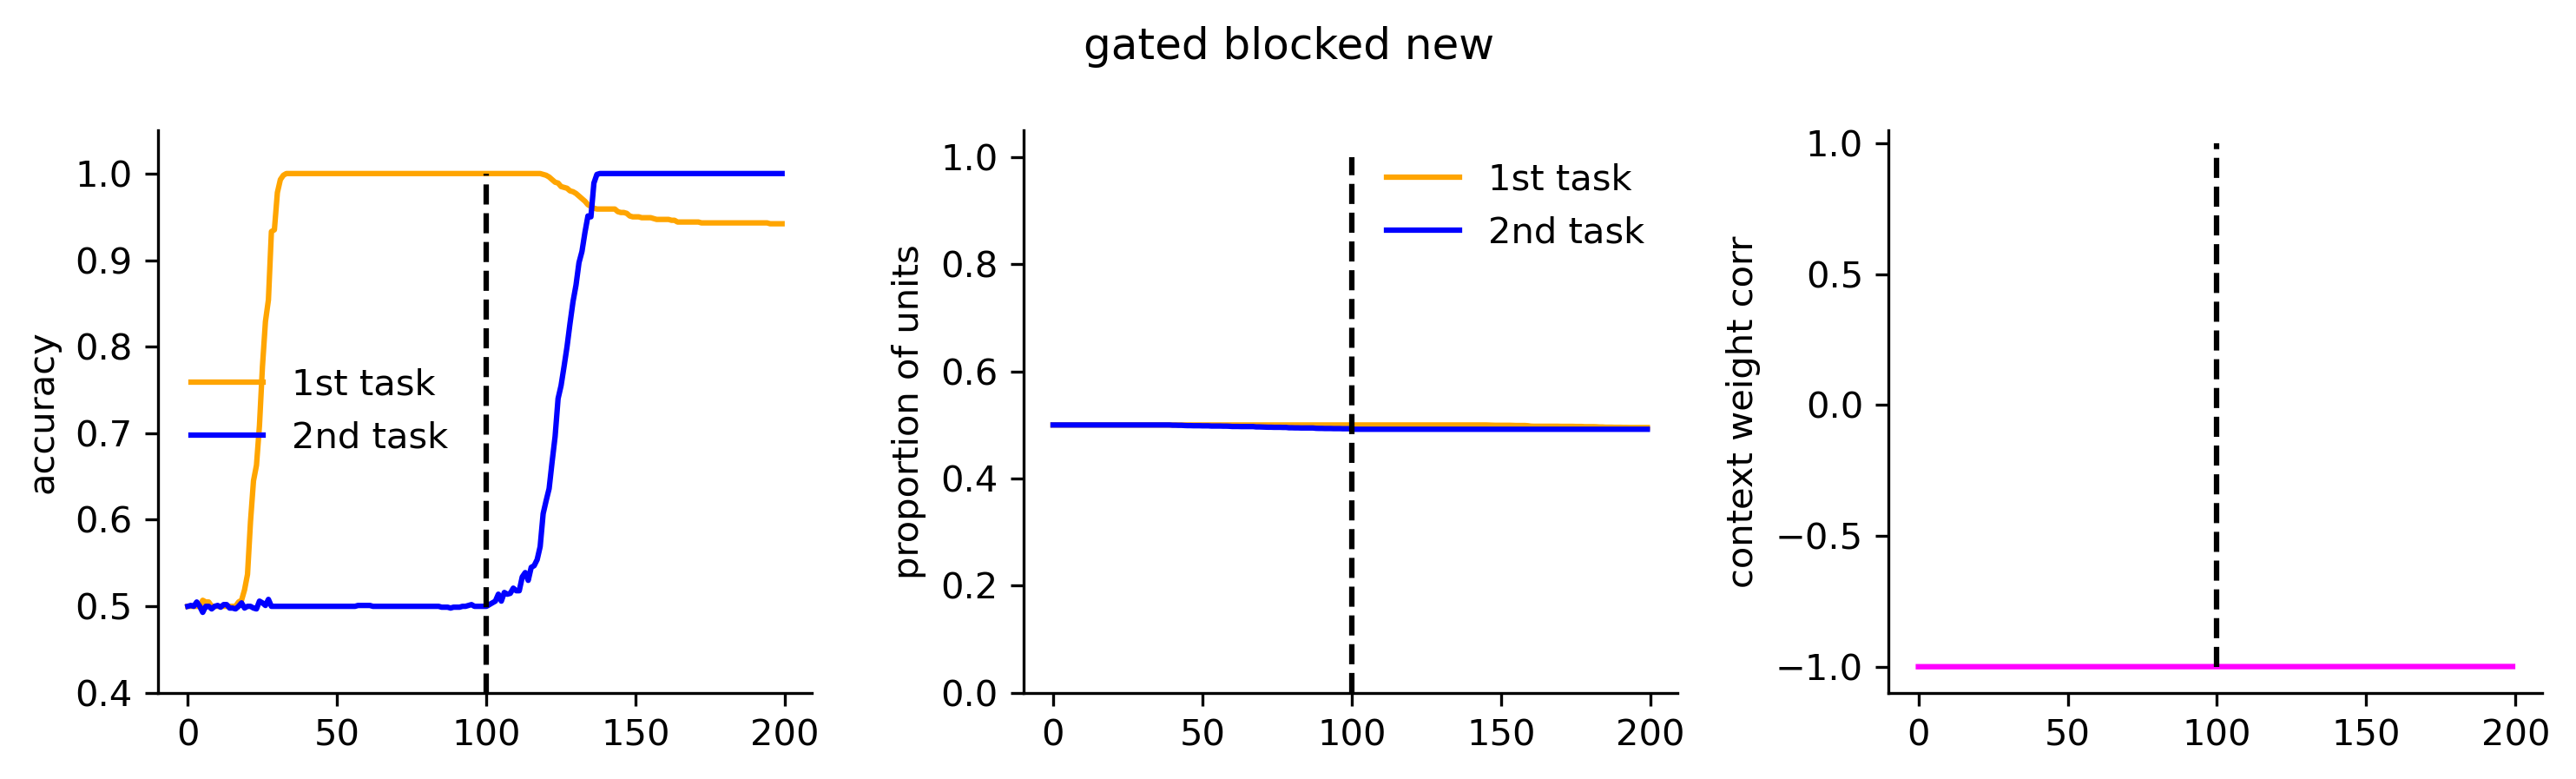

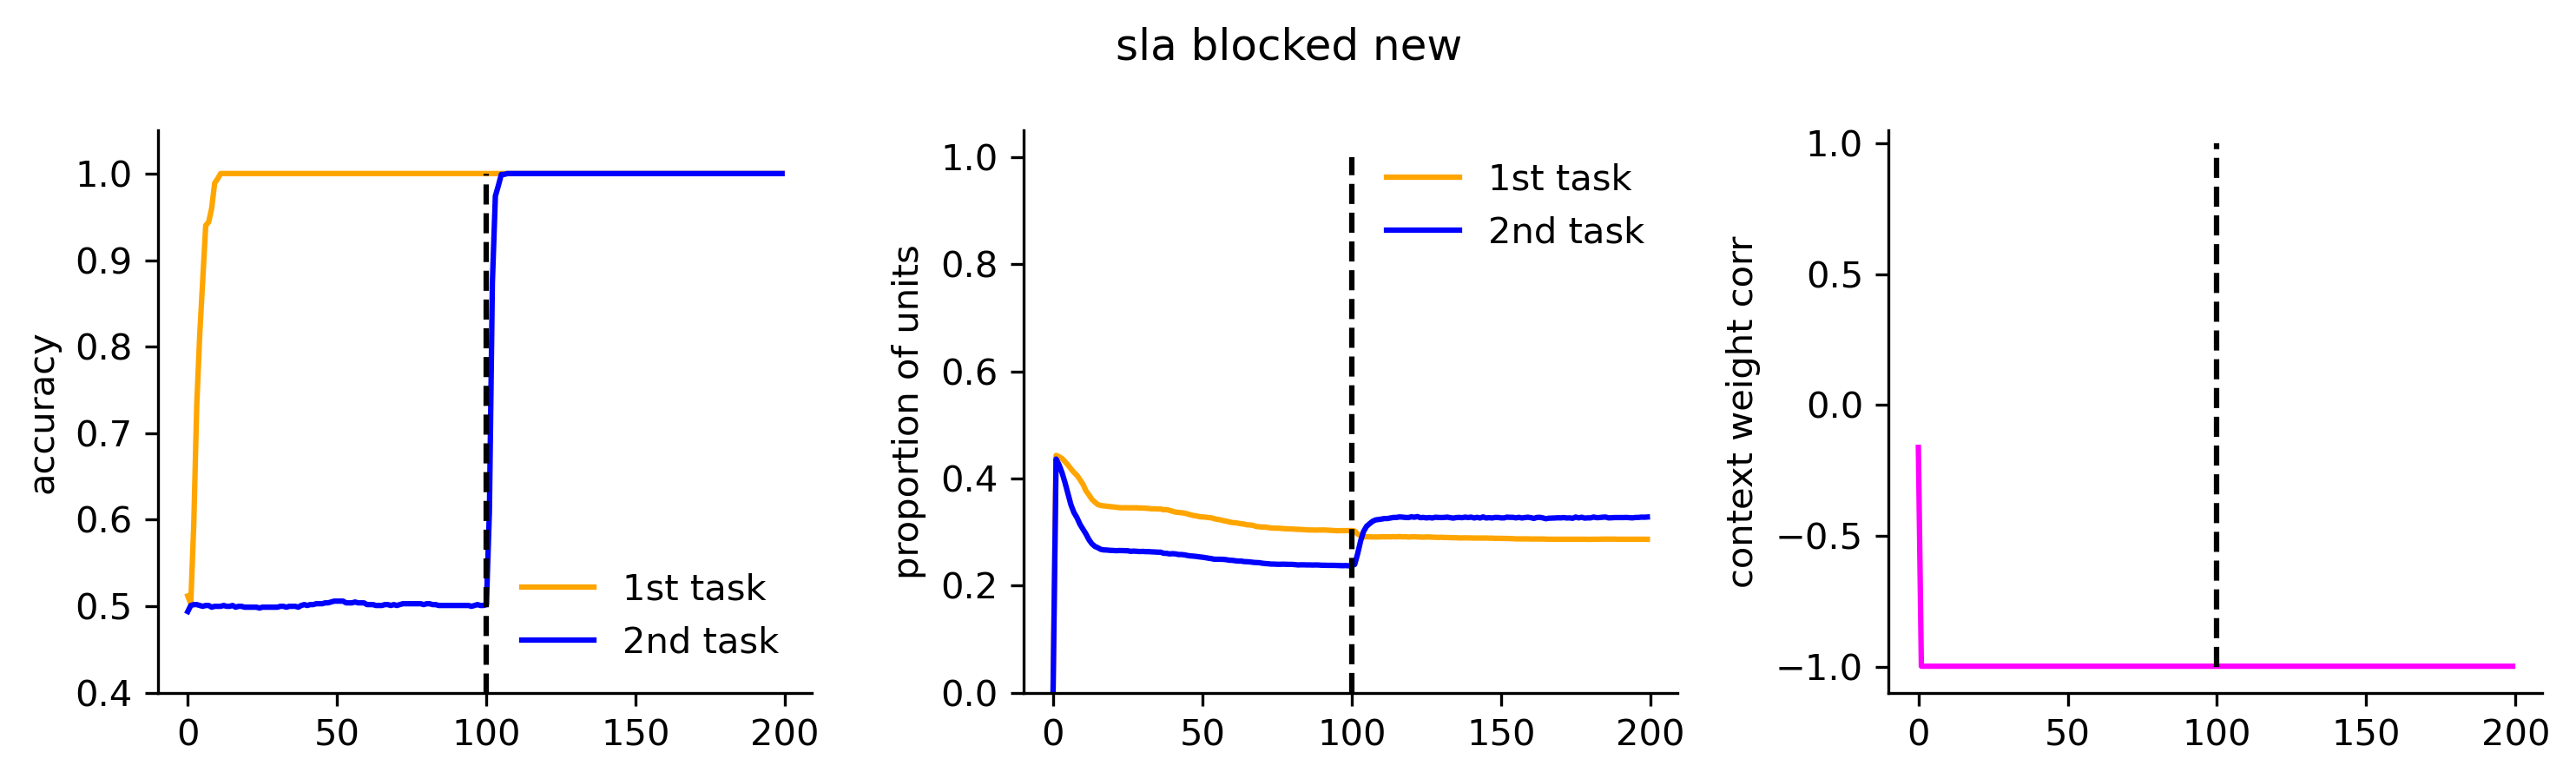

In [722]:
n_runs = 50
models = ['baseline_interleaved_new', 'baseline_blocked_new',
          'gated_blocked_new', 'sla_blocked_new']

for i,m in enumerate(models):
    f, axs = plt.subplots(1,3,figsize=(10,3),dpi=300)
    t_a = np.empty((n_runs,200))
    t_b = np.empty((n_runs,200))
    t_d = np.empty((n_runs,200))
    t_mixed = np.empty((n_runs,200))
    acc_1st = np.empty((n_runs,200))
    acc_2nd = np.empty((n_runs,200))
    contextcorr = np.empty((n_runs,200))

    for r in range(n_runs):
        with open('checkpoints/'+m+'/run_'+str(r)+'/results.pkl', 'rb') as f:
            results = pickle.load(f)
            t_a[r,:] = results['n_only_a']/100
            t_b[r,:] = results['n_only_b']/100
            # t_d[r,:] = results['n_dead']/100
            # t_mixed[r,:] = 1-t_a[r,:]-t_b[r,:]-t_d[r,:]
            if m=='gated_blocked':
                contextcorr[r,:] = [-1]*200
            else:
                contextcorr[r,:] = results['w_context_corr']
            acc_1st[r,:] = results['acc_1st']
            acc_2nd[r,:] = results['acc_2nd']
    
    axs[0].plot(np.arange(200),acc_1st.mean(0),color='orange')
    axs[0].plot(np.arange(200),acc_2nd.mean(0),color='blue')
    axs[0].set_ylim([0.4,1.05])
    axs[0].set(ylabel='accuracy')
    axs[0].legend(['1st task','2nd task'],frameon=False)
    axs[0].plot([100,100],[0,1],'k--')
    plt.suptitle(m.replace('_',' '))
    sns.despine()


    axs[1].plot(np.arange(200),t_b.mean(0),color='orange')
    axs[1].plot(np.arange(200),t_a.mean(0),color='blue')
    # axs[1].plot(np.arange(200),t_mixed.mean(0),color='darkgreen',linestyle='--')
    # axs[1].plot(np.arange(200),t_d.mean(0),color='red',linestyle='--')
    plt.suptitle(m.replace('_',' '))
    axs[1].set_ylim([0,1.05])
    axs[1].set(ylabel='proportion of units')
    axs[1].legend(['1st task','2nd task'],frameon=False)
    axs[1].plot([100,100],[0,1],'k--')
    sns.despine()

    axs[2].plot(np.arange(200),contextcorr.mean(0),color='magenta')    
    plt.suptitle(m.replace('_',' '))
    axs[2].set_ylim([-1.1,1.05])
    axs[2].set(ylabel='context weight corr')    
    axs[2].plot([100,100],[-1,1],'k--')
    sns.despine()
    plt.tight_layout()
